In [1]:
import pandas as pd
import re
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import nltk
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim
from joblib import Parallel, delayed
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import dill
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, f_oneway, kruskal
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-colorblind')


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# General data preprocessing

### Authors' personality traits dataset preparation

In [2]:
author_personality = pd.read_json('author_liwc.jsonl.bz2', lines=True, compression='bz2')

traits_unpacked = pd.json_normalize(author_personality['traits'])

# Combine with original data
author_personality = pd.concat([author_personality.drop('traits', axis=1), traits_unpacked], axis=1)
author_personality = author_personality[['author', 'content_date'] +
                 list(author_personality.filter(like='liwc_scores').columns)]


author_personality = author_personality.loc[:, ~author_personality.columns.duplicated(keep='first')]
author_personality['content_date'] = pd.to_datetime(author_personality['content_date'])
author_personality.head()

,author,content_date,liwc_scores.tone,liwc_scores.wc,liwc_scores.authentic,liwc_scores.sixLtr,liwc_scores.categories.compare,liwc_scores.categories.auxverb,liwc_scores.categories.affect,liwc_scores.categories.discrep,...,liwc_scores.categories.focuspresent,liwc_scores.categories.sad,liwc_scores.categories.negate,liwc_scores.categories.prep,liwc_scores.categories.see,liwc_scores.categories.leisure,liwc_scores.clout,liwc_scores.dic,liwc_scores.analytic,liwc_scores.wps
0,KnuteViking,2019-03-31 23:43:42.572548+00:00,40.713577,8437,27.628368,0.191537,0.028091,0.106436,0.049662,0.020979,...,0.128363,0.001541,0.028565,0.136778,0.008297,0.005215,70.445540,0.887875,52.017810,16.773360
1,Brohozombie,2019-03-31 23:55:23.915410+00:00,56.632114,1714,35.595460,0.177363,0.022170,0.103267,0.052509,0.024504,...,0.123104,0.002917,0.017503,0.122520,0.013419,0.006418,70.641050,0.855309,58.464510,15.035088
2,z00mbinis,2019-04-01 05:02:07.975049+00:00,36.354030,5312,39.531320,0.146649,0.025791,0.121988,0.053276,0.026167,...,0.150414,0.000941,0.035580,0.118035,0.006965,0.007342,64.824850,0.890437,33.200700,16.195122
3,ChangeAndAdapt,2019-04-01 03:28:03.198260+00:00,61.238610,1497,54.277485,0.207749,0.025384,0.098196,0.040080,0.016032,...,0.142285,0.000000,0.024048,0.136273,0.009352,0.006680,49.732800,0.870407,52.840920,16.633333
4,OwMyBoatingArm,2019-04-01 01:37:30.593014+00:00,40.291954,9770,25.902409,0.185875,0.029990,0.088639,0.043501,0.022620,...,0.119243,0.003582,0.016172,0.133163,0.005425,0.004401,63.812374,0.848516,73.667465,16.475548


In [3]:
author_personality['content_date'].min(), author_personality['content_date'].max()

(Timestamp('2019-03-31 22:38:14.985069+0000', tz='UTC'),
 Timestamp('2019-04-02 14:16:42.617858+0000', tz='UTC'))

### Main text data - pairs of delta-non-delta

In [4]:
pairs_df = pd.read_json('pairs.jsonl.bz2', lines=True, compression='bz2')

# Extract 'delta' and 'author' from the first comment in each list
pairs_df['delta_true'] = pairs_df['delta_comment'].apply(lambda x: x['delta'])
pairs_df['author_delta'] = pairs_df['delta_comment'].apply(lambda x: x['author'])

pairs_df['delta_false'] = pairs_df['nodelta_comment'].apply(lambda x: x['delta'])
pairs_df['author_nodelta'] = pairs_df['nodelta_comment'].apply(lambda x: x['author'])

# Concatenate all 'body' fields from the 'comments' list
pairs_df['text_delta'] = pairs_df['delta_comment'].apply(
    lambda x: '\n'.join([c['body'] for c in x['comments'] if 'body' in c])
)

pairs_df['text_nodelta'] = pairs_df['nodelta_comment'].apply(
    lambda x: '\n'.join([c['body'] for c in x['comments'] if 'body' in c])
)

# Process 'submission' field
pairs_df['submission_text'] = pairs_df['submission'].apply(
    lambda x: (x.get('title', '') + ' ' + x.get('selftext', '')).strip()
)
pairs_df['submission_author'] = pairs_df['submission'].apply(lambda x: x.get('author', ''))

# Drop the original nested column if you don't need it anymore
pairs_df = pairs_df.drop(['delta_comment', 'nodelta_comment', 'submission'], axis=1)
pairs_df.head()

,comments_similarity,submission_id,delta_true,author_delta,delta_false,author_nodelta,text_delta,text_nodelta,submission_text,submission_author
0,0.104265,t3_30oi71,True,DaystarEld,False,catastematic,The majority of your points seem predicated on...,Question: you seem to assume that we must have...,CMV: We should strengthen the traditional safe...,gobears10
1,0.142405,t3_30oi71,True,ElGuapoBlanco,False,Godspiral,&gt; Section V: Does the Welfare Trap Truly Ex...,A variation of strengthening existing welfare ...,CMV: We should strengthen the traditional safe...,gobears10
2,0.169856,t3_30oi71,True,TRC_esq,False,funchy,"First, your disagreements about different fund...",You have created a false dichotomy of only tho...,CMV: We should strengthen the traditional safe...,gobears10
3,0.080851,t3_30oi71,True,C-LAR,False,Godspiral,your position rests on the assumption that mos...,A variation of strengthening existing welfare ...,CMV: We should strengthen the traditional safe...,gobears10
4,0.126984,t3_4gdj35,True,AmoebaMan,False,FlyingFoxOfTheYard_,You seem to be basing your entire argument on ...,&gt; I am of the belief that there cannot exis...,CMV: Males and Females are socially and emotio...,TaslaVenhyle


In [5]:
delta_df = pairs_df.drop(['comments_similarity','text_nodelta', 'delta_false', 'author_nodelta'], axis=1)
delta_df = delta_df.drop_duplicates()
delta_df = delta_df.rename(columns={
    'text_delta': 'text',
    'delta_true': 'delta',
    'author_delta': 'author'
})
delta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10303 entries, 0 to 10302
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   submission_id      10303 non-null  object
 1   delta              10303 non-null  bool  
 2   author             10303 non-null  object
 3   text               10303 non-null  object
 4   submission_text    10303 non-null  object
 5   submission_author  10303 non-null  object
dtypes: bool(1), object(5)
memory usage: 412.7+ KB


In [6]:
nodelta_df = pairs_df.drop(['comments_similarity','text_delta', 'delta_true', 'author_delta'], axis=1)
nodelta_df = nodelta_df.drop_duplicates()
nodelta_df = nodelta_df.rename(columns={
    'text_nodelta': 'text',
    'delta_false': 'delta',
    'author_nodelta': 'author'
})

nodelta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9028 entries, 0 to 10302
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   submission_id      9028 non-null   object
 1   delta              9028 non-null   bool  
 2   author             9028 non-null   object
 3   text               9028 non-null   object
 4   submission_text    9028 non-null   object
 5   submission_author  9028 non-null   object
dtypes: bool(1), object(5)
memory usage: 432.0+ KB


In [7]:
final_df = pd.concat([delta_df, nodelta_df])

final_df.head()

,submission_id,delta,author,text,submission_text,submission_author
0,t3_30oi71,True,DaystarEld,The majority of your points seem predicated on...,CMV: We should strengthen the traditional safe...,gobears10
1,t3_30oi71,True,ElGuapoBlanco,&gt; Section V: Does the Welfare Trap Truly Ex...,CMV: We should strengthen the traditional safe...,gobears10
2,t3_30oi71,True,TRC_esq,"First, your disagreements about different fund...",CMV: We should strengthen the traditional safe...,gobears10
3,t3_30oi71,True,C-LAR,your position rests on the assumption that mos...,CMV: We should strengthen the traditional safe...,gobears10
4,t3_4gdj35,True,AmoebaMan,You seem to be basing your entire argument on ...,CMV: Males and Females are socially and emotio...,TaslaVenhyle


### Adding personality traits data

In [8]:
final_df = final_df.merge(
    author_personality,
    left_on='submission_author',
    right_on='author',
    how='left'
)
final_df = final_df.drop('author_y', axis=1)
final_df.head()


,submission_id,delta,author_x,text,submission_text,submission_author,content_date,liwc_scores.tone,liwc_scores.wc,liwc_scores.authentic,...,liwc_scores.categories.focuspresent,liwc_scores.categories.sad,liwc_scores.categories.negate,liwc_scores.categories.prep,liwc_scores.categories.see,liwc_scores.categories.leisure,liwc_scores.clout,liwc_scores.dic,liwc_scores.analytic,liwc_scores.wps
0,t3_30oi71,True,DaystarEld,The majority of your points seem predicated on...,CMV: We should strengthen the traditional safe...,gobears10,2019-04-01 04:17:57.868699+00:00,64.199135,9868.0,14.313471,...,0.085529,0.004864,0.014187,0.138731,0.003547,0.003344,55.351162,0.80685,84.30521,25.17347
1,t3_30oi71,True,ElGuapoBlanco,&gt; Section V: Does the Welfare Trap Truly Ex...,CMV: We should strengthen the traditional safe...,gobears10,2019-04-01 04:17:57.868699+00:00,64.199135,9868.0,14.313471,...,0.085529,0.004864,0.014187,0.138731,0.003547,0.003344,55.351162,0.80685,84.30521,25.17347
2,t3_30oi71,True,TRC_esq,"First, your disagreements about different fund...",CMV: We should strengthen the traditional safe...,gobears10,2019-04-01 04:17:57.868699+00:00,64.199135,9868.0,14.313471,...,0.085529,0.004864,0.014187,0.138731,0.003547,0.003344,55.351162,0.80685,84.30521,25.17347
3,t3_30oi71,True,C-LAR,your position rests on the assumption that mos...,CMV: We should strengthen the traditional safe...,gobears10,2019-04-01 04:17:57.868699+00:00,64.199135,9868.0,14.313471,...,0.085529,0.004864,0.014187,0.138731,0.003547,0.003344,55.351162,0.80685,84.30521,25.17347
4,t3_4gdj35,True,AmoebaMan,You seem to be basing your entire argument on ...,CMV: Males and Females are socially and emotio...,TaslaVenhyle,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Show rows where a column has NaN
len(final_df[final_df['content_date'].isna()]['submission_author'].unique())

975

What do we have in the final dataset:

'submission_' columns refer to the initial post with opinion to be changed

'author_x' - author of the comment with an attempt to change opnion - the one should receive delta

'text' - column with the content of persuasion attempt - the one to receive delta

All personality traits columns refer to authors of the initial post


# Topic modeling

In [ ]:
# 1. Group by the submission ID and other metadata you want to keep
# 2. Aggregating 'submission_text' with 'first' (since it's the same for all rows in a group)
# 3: "Aggregating 'text' by joining all comments into one long string
ds_reddit = (
    final_df.groupby('submission_id')
    .agg({
        'submission_text': 'first',
        'text': lambda x: ' '.join(x.astype(str)),
        'submission_author': 'first',
        'content_date': 'first'
    })
    .reset_index()
)

# 4: "Create the 'thread' column by concatenating the post and the joined comments
ds_reddit['thread'] = ds_reddit['submission_text'] + " " + ds_reddit['text']

# 5: "Drop the intermediate columns if you only want the final 'thread'
ds_reddit = ds_reddit[['submission_id', 'submission_text','thread', 'submission_author', 'content_date']]
print(f"Number of documents: {len(ds_reddit)}")
ds_reddit.head()

Number of documents: 5990


,submission_id,submission_text,thread,submission_author,content_date
0,t3_181jmd,Here's what I would change about American gun ...,Here's what I would change about American gun ...,spblat,2019-04-01 02:06:36.175542+00:00
1,t3_189t2t,I don't understand what people find wrong with...,I don't understand what people find wrong with...,resij,2019-03-31 23:19:55.443195+00:00
2,t3_18dj9h,I believe there are no valid arguments for eat...,I believe there are no valid arguments for eat...,Ashaar,2019-04-01 03:05:27.498671+00:00
3,t3_18fnmc,I get internally furious whenever girls/guys i...,I get internally furious whenever girls/guys i...,itaremeelar,2019-04-01 03:43:39.595723+00:00
4,t3_18n2uc,I believe those who want power shouldn't have ...,I believe those who want power shouldn't have ...,rastarat,NaT


In [11]:
# Helper functions for topic analysis

# Function to assign the dominant topic to each document
def texts_to_topic(document_topic_matrix, drop_columns=None):
    if drop_columns is None:
        # Find the index of the maximum value in each row
        dominant_topic_indices = np.argmax(document_topic_matrix.values, axis=1)
    else:
        # Find the index of the maximum value excluding certain columns
        dominant_topic_indices = np.argmax(document_topic_matrix.drop(drop_columns, axis=1).values, axis=1)

    # Adjust indices if columns were dropped
    if drop_columns is not None:
        # Create a mapping from original indices to indices after dropping
        original_columns = document_topic_matrix.columns.tolist()
        remaining_columns = document_topic_matrix.drop(drop_columns, axis=1).columns.tolist()
        index_map = {i: original_columns.index(col) for i, col in enumerate(remaining_columns)}
        dominant_topic_indices = np.array([index_map[idx] for idx in dominant_topic_indices])

    dominant_topics = pd.DataFrame(["topic_" + str(index) for index in dominant_topic_indices],
                               columns=["dominant_topic"],
                               index=document_topic_matrix.index)
    return dominant_topics

# Function to get the N most important words per topic
def top_words_per_topic(term_topic_matrix, n_top_words):
    top_words_df = pd.DataFrame()
    top_scores_df = pd.DataFrame()
    for topic in term_topic_matrix.columns:
        # Use abs() for LSA as values can be negative
        top_indices = term_topic_matrix[topic].abs().nlargest(n_top_words).index.tolist()
        top_words = term_topic_matrix.loc[top_indices, topic].index.tolist()
        top_scores = term_topic_matrix.loc[top_indices, topic].tolist()
        top_words_df[topic] = top_words
        top_scores_df[topic] = top_scores
    return [top_words_df, top_scores_df]

# Function to assign the top N topics to each document
def texts_to_n_topics(document_topic_matrix, n=2):
    # Use abs() for LSA
    top_n_indices = np.argsort(np.abs(document_topic_matrix.values), axis=1)[:, -n:][:, ::-1]
    top_n_topics = pd.DataFrame(index=document_topic_matrix.index)
    for i in range(n):
        top_n_topics[f'top_topic_{i + 1}'] = [document_topic_matrix.columns[idx]
                                              for idx in top_n_indices[:, i]]
    return top_n_topics

# LDA

### Preprocessing

In [ ]:
# Downloads
spacy.cli.download("en_core_web_sm")
nlp = spacy.load(
    "en_core_web_sm",
    disable=["tok2vec", "tagger", "parser", "ner"]
)

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
stop_words_en = set(nltk.corpus.stopwords.words("english"))

In [17]:
# Stopwords & Lemmatizer

lemmatizer = nltk.stem.WordNetLemmatizer()

CUSTOM_REMOVE_WORDS = {
    "'s", "n't", "'re", "'ve", "'ll", "'d", "’s", "’t"
}

def custom_tokenizer(text):
    doc = nlp(text.lower())
    tokens = []
    for tok in doc:
        # Remove punctuation, numbers, spaces
        if tok.is_punct or tok.is_space or tok.like_num:
            continue
        token = tok.text.strip()
        # Remove empty tokens
        if not token:
            continue
        # Remove stopwords and custom words
        if token in stop_words_en or token in CUSTOM_REMOVE_WORDS:
            continue
        # Remove contraction leftovers
        if token.startswith("'") or token.endswith("'"):
            continue
        # Optional: keep alphabetic tokens only (recommended for LDA)
        if not token.isalpha():
            continue
        
        # Lemmatize with multiple POS tags
        # Try verb first
        lemma = lemmatizer.lemmatize(token, pos="v")
        # If unchanged, try noun
        if lemma == token:
            lemma = lemmatizer.lemmatize(token, pos="n")
        # If still unchanged, try adjective
        if lemma == token:
            lemma = lemmatizer.lemmatize(token, pos="a")
        # If still unchanged, try adverb (optional)
        if lemma == token:
            lemma = lemmatizer.lemmatize(token, pos="r")
        
        tokens.append(lemma)
    return tokens

# CountVectorizer for LDA
reddit_tokenizer_bow = CountVectorizer(
    tokenizer=custom_tokenizer,
    lowercase=True,
    stop_words=None,   # handled in tokenizer
    max_df=0.90,
    min_df=0.005
)

reddit_bow = reddit_tokenizer_bow.fit_transform(
    ds_reddit["thread"]
)

print(f"BoW Matrix Dimensions: {reddit_bow.shape}")


BoW Matrix Dimensions: (5990, 6216)


## Grid search for lowest perplexity

In [18]:
X_train, X_test = train_test_split(
    reddit_bow,
    test_size=0.2,
    random_state=42
)


In [19]:
k_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
alpha_values = [None, 0.1]
beta_values  = [None, 0.15, 0.2]


results = []


In [20]:
def evaluate_lda(k, alpha, beta):
    from sklearn.decomposition import LatentDirichletAllocation

    lda = LatentDirichletAllocation(
        n_components=k,
        doc_topic_prior=alpha,
        topic_word_prior=beta,
        learning_method='online',
        random_state=123,
        n_jobs=1   # MUST be 1
    )

    # CRITICAL: make writable copies INSIDE worker
    Xtr = X_train.copy()
    Xte = X_test.copy()

    lda.fit(Xtr)

    return {
        'k': k,
        'alpha': alpha,
        'beta': beta,
        'perplexity': lda.perplexity(Xte)
    }


In [21]:
from joblib import Parallel, delayed

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(evaluate_lda)(k, alpha, beta)
    for k in k_values
    for alpha in alpha_values
    for beta in beta_values
)

results_df = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed: 11.1min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed: 11.5min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed: 13.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed: 13.7min remaining:   43.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.8min finished


In [22]:
best_per_k = (
    results_df
    .sort_values('perplexity')
    .groupby('k')
    .first()
    .reset_index()
)

print(best_per_k)


    k  alpha  beta   perplexity
0   3    0.1  0.20  1765.143338
1   4    0.1  0.20  1743.118349
2   5    0.1  0.20  1749.367793
3   6    0.1  0.20  1721.268253
4   7    0.1  0.20  1713.473458
5   8    0.1  0.20  1711.391429
6   9    0.1  0.20  1716.617578
7  10    0.1  0.20  1712.443302
8  11    0.1  0.15  1712.214164
9  12    0.1  0.15  1719.951484


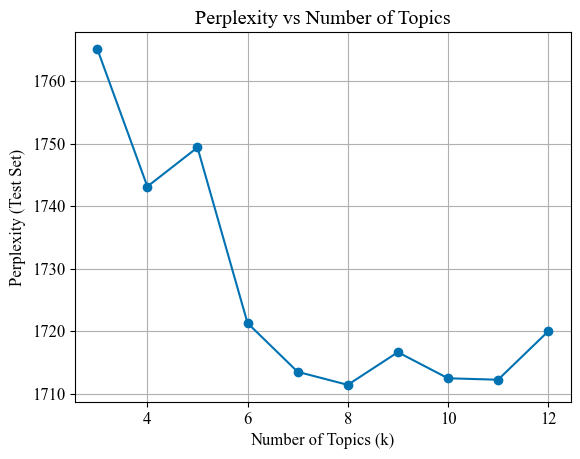

In [23]:
# Plot Perplexity vs k - choose elbow point (better topic interpretability)

plt.figure()
plt.plot(best_per_k['k'], best_per_k['perplexity'], marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Perplexity (Test Set)")
plt.title("Perplexity vs Number of Topics")
plt.grid(True)
plt.show()


## Coherence score

In [24]:
# Get feature names (vocabulary)
feature_names = reddit_tokenizer_bow.get_feature_names_out()

# Convert sparse matrix to token lists
reddit_texts_tokenized = []

# reddit_bow is sparse matrix of shape (n_docs, n_words)
for doc_idx in range(reddit_bow.shape[0]):
    row = reddit_bow[doc_idx]
    # row.indices = indices of words present in this document
    # row.data = counts of those words
    tokens = []
    for idx, count in zip(row.indices, row.data):
        tokens.extend([feature_names[idx]] * count)
    reddit_texts_tokenized.append(tokens)


dictionary = Dictionary(reddit_texts_tokenized)


In [25]:
def get_topics(lda_model, feature_names, top_n=10):
    topics = []
    for topic_weights in lda_model.components_:
        top_indices = topic_weights.argsort()[-top_n:]
        topics.append([feature_names[i] for i in top_indices])
    return topics


In [26]:
coherence_scores = []

for _, row in best_per_k.iterrows():
    lda = LatentDirichletAllocation(
        n_components=int(row['k']),
        doc_topic_prior=row['alpha'],
        topic_word_prior=row['beta'],
        learning_method='online',
        random_state=123
    )

    lda.fit(reddit_bow)

    topics = get_topics(lda, feature_names)

    coherence_model = CoherenceModel(
        topics=topics,
        texts=reddit_texts_tokenized,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append({
        'k': row['k'],
        'coherence': coherence_model.get_coherence()
    })


In [27]:
coherence_df = pd.DataFrame(coherence_scores)
print(coherence_df)


      k  coherence
0   3.0   0.647686
1   4.0   0.526167
2   5.0   0.447252
3   6.0   0.432929
4   7.0   0.410050
5   8.0   0.417444
6   9.0   0.435932
7  10.0   0.404623
8  11.0   0.427450
9  12.0   0.366685


In [28]:
stats_df = best_per_k.merge(coherence_df, on='k')
print(stats_df)

    k  alpha  beta   perplexity  coherence
0   3    0.1  0.20  1765.143338   0.647686
1   4    0.1  0.20  1743.118349   0.526167
2   5    0.1  0.20  1749.367793   0.447252
3   6    0.1  0.20  1721.268253   0.432929
4   7    0.1  0.20  1713.473458   0.410050
5   8    0.1  0.20  1711.391429   0.417444
6   9    0.1  0.20  1716.617578   0.435932
7  10    0.1  0.20  1712.443302   0.404623
8  11    0.1  0.15  1712.214164   0.427450
9  12    0.1  0.15  1719.951484   0.366685


### Rule of thumb

Perplexity ↓

Coherence ↑

Pick best trade-off, not just lowest perplexity

In [34]:
# Final model
# best_row = final_df.sort_values(
#     by=['coherence', 'perplexity'],
#     ascending=[False, True]
# ).iloc[0]
best_row = stats_df.iloc[6]

lda = LatentDirichletAllocation(
    n_components=int(best_row['k']),
    doc_topic_prior=best_row['alpha'],
    topic_word_prior=best_row['beta'],
    random_state=123
)

reddit_document_topic_matrix_lda = lda.fit_transform(reddit_bow)


In [35]:
# Document-Topic Matrix (Theta)
# This matrix represents the probability of each topic in each document.
reddit_document_topic_matrix_lda = pd.DataFrame(reddit_document_topic_matrix_lda,
                                            columns=[f'topic_{i}' for i in
                                                     range(lda.n_components)],
                                            index=[f'text_{i}' for i in
                                                   range(reddit_document_topic_matrix_lda.shape[0])])
print("\nDocument-Topic Matrix (LDA - First 5 rows):")
print(reddit_document_topic_matrix_lda.head())

# Term-Topic Matrix (Phi)
# This matrix represents the probability of each word given a topic (word-per-topic distribution).
reddit_term_topic_matrix_lda = lda.components_.T
# Normalize components to get probabilities (sum to 1 per column)
reddit_term_topic_matrix_lda = reddit_term_topic_matrix_lda / reddit_term_topic_matrix_lda.sum(axis=0, keepdims=True)
reddit_term_topic_matrix_lda = pd.DataFrame(reddit_term_topic_matrix_lda,
                                        columns=[f'topic_{i}' for i in
                                                 range(lda.n_components)],
                                        index=reddit_tokenizer_bow.get_feature_names_out())
print("\nTerm-Topic Matrix (LDA - First 5 rows):")
print(reddit_term_topic_matrix_lda.head())


Document-Topic Matrix (LDA - First 5 rows):
         topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
text_0  0.030787  0.000159  0.164756  0.000159  0.711105  0.000159  0.000159   
text_1  0.000104  0.106946  0.016894  0.333779  0.000104  0.000104  0.011730   
text_2  0.000105  0.014371  0.000105  0.470075  0.000105  0.024915  0.000105   
text_3  0.000185  0.007995  0.000185  0.000185  0.000185  0.387959  0.000185   
text_4  0.615185  0.066126  0.096382  0.026656  0.000307  0.118587  0.076143   

         topic_7   topic_8  
text_0  0.092555  0.000159  
text_1  0.000104  0.530236  
text_2  0.177433  0.312787  
text_3  0.000185  0.602935  
text_4  0.000307  0.000307  

Term-Topic Matrix (LDA - First 5 rows):
            topic_0   topic_1   topic_2   topic_3   topic_4       topic_5  \
abandon    0.000087  0.000087  0.000030  0.000116  0.000126  2.588739e-05   
abhorrent  0.000049  0.000021  0.000007  0.000028  0.000026  4.225664e-07   
abide      0.000027  0.00008

In [63]:
# We use the `texts_to_topic` function (no `abs()` required for LDA)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
reddit_topics_lda = texts_to_topic(document_topic_matrix=reddit_document_topic_matrix_lda)
print("\nDocument count by dominant topic (LDA): ")
print(reddit_topics_lda.value_counts("dominant_topic").sort_index().head(10))




Document count by dominant topic (LDA): 
dominant_topic
topic_0    760
topic_1    530
topic_2    681
topic_3    771
topic_4    617
topic_5    816
topic_6    615
topic_7    329
topic_8    871
Name: count, dtype: int64


In [37]:
# Top Words per Topic (LDA)
# We use a slightly modified function for LDA since we don't need abs() and scores are probabilities
def top_words_per_topic_lda(term_topic_matrix, n_top_words):
    top_words_df = pd.DataFrame()
    top_scores_df = pd.DataFrame()
    for topic in term_topic_matrix.columns:
        top_words = term_topic_matrix[topic].nlargest(n_top_words).index.tolist()
        top_scores = term_topic_matrix[topic].nlargest(n_top_words).tolist()
        top_words_df[topic] = top_words
        top_scores_df[topic] = top_scores
    return [top_words_df, top_scores_df]

reddit_top_words_lda = top_words_per_topic_lda(term_topic_matrix=reddit_term_topic_matrix_lda,
                                       n_top_words=50)

top_words_df = reddit_top_words_lda[0]

print("\n--- Top Words per Topic ---")
for topic_name in top_words_df.columns:
    words = top_words_df[topic_name].values
    print(f"\n{topic_name}:")
    print(", ".join(words))

# Top N Topics per Document (LDA)
# We use a slightly modified function for LDA since we don't need abs()
def texts_to_n_topics_lda(document_topic_matrix, n=2):
    top_n_indices = np.argsort(document_topic_matrix.values, axis=1)[:, -n:][:, ::-1]
    top_n_topics = pd.DataFrame(index=document_topic_matrix.index)
    for i in range(n):
        top_n_topics[f'top_topic_{i + 1}'] = [document_topic_matrix.columns[idx]
                                              for idx in top_n_indices[:, i]]
    return top_n_topics



# 6.4. Save results for later analysis
with open('reddit_top_words_lda.dill', 'wb') as f:
    dill.dump(reddit_top_words_lda, f)


--- Top Words per Topic ---

topic_0:
vote, trump, say, black, white, like, make, right, get, party, political, change, want, issue, state, thing, view, go, see, even, republican, good, candidate, way, election, policy, system, point, racist, know, president, support, government, group, believe, u, could, also, american, much, voter, many, really, liberal, power, conservative, time, mean, country, racism

topic_1:
say, religion, like, word, use, culture, mean, believe, make, thing, religious, god, way, christian, belief, different, see, view, person, someone, group, even, call, language, many, know, go, example, something, point, also, gay, change, really, gt, feel, understand, right, come, idea, name, argument, black, part, want, wrong, society, reason, good, get

topic_2:
money, pay, work, get, make, job, government, go, good, tax, want, company, business, give, take, need, system, like, say, cost, thing, could, drug, service, free, even, much, right, time, use, high, live, year, al

In [38]:
reddit_n_topics_lda = texts_to_n_topics_lda(document_topic_matrix=reddit_document_topic_matrix_lda,
                                    n = 3)
print("\nTop 5 topics per document (LDA - First 5 rows):")
print(reddit_n_topics_lda.head)


Top 5 topics per document (LDA - First 5 rows):
<bound method NDFrame.head of           top_topic_1 top_topic_2 top_topic_3
text_0        topic_4     topic_2     topic_7
text_1        topic_8     topic_3     topic_1
text_2        topic_3     topic_8     topic_7
text_3        topic_8     topic_5     topic_1
text_4        topic_0     topic_5     topic_2
text_5        topic_5     topic_3     topic_8
text_6        topic_3     topic_1     topic_6
text_7        topic_2     topic_3     topic_5
text_8        topic_1     topic_3     topic_6
text_9        topic_5     topic_2     topic_6
text_10       topic_0     topic_4     topic_1
text_11       topic_8     topic_5     topic_1
text_12       topic_2     topic_7     topic_4
text_13       topic_3     topic_7     topic_8
text_14       topic_8     topic_5     topic_0
text_15       topic_2     topic_5     topic_6
text_16       topic_7     topic_3     topic_6
text_17       topic_8     topic_7     topic_3
text_18       topic_5     topic_3     topic_4
t

In [39]:
# Assuming reddit_document_topic_matrix_lda contains your LDA scores
# Get indices of the top 3 topics for each row
top_3_indices = np.argsort(reddit_document_topic_matrix_lda.values, axis=1)[:, -3:][:, ::-1]

# Extract the scores for these top 3 topics
top_3_scores = np.sort(reddit_document_topic_matrix_lda.values, axis=1)[:, -3:][:, ::-1]

# Add to ds_reddit
for i in range(3):
    # Categorical: The topic name/ID
    ds_reddit[f'top_topic_{i+1}'] = [reddit_document_topic_matrix_lda.columns[idx] for idx in top_3_indices[:, i]]
    # Numerical: The actual LDA score
    ds_reddit[f'top_topic_{i+1}_score'] = top_3_scores[:, i]

In [40]:
# Let's return data on personality traits

ds_reddit = ds_reddit.merge(
    author_personality, 
    left_on='submission_author', 
    right_on='author', 
    how='left', 
    suffixes=('', '_submission_author')
)

ds_reddit.head()

,submission_id,submission_text,thread,submission_author,content_date,top_topic_1,top_topic_1_score,top_topic_2,top_topic_2_score,top_topic_3,top_topic_3_score,author,content_date_submission_author,liwc_scores.tone,liwc_scores.wc,liwc_scores.authentic,liwc_scores.sixLtr,liwc_scores.categories.compare,liwc_scores.categories.auxverb,liwc_scores.categories.affect,liwc_scores.categories.discrep,liwc_scores.categories.Colon,liwc_scores.categories.they,liwc_scores.categories.Parenth,liwc_scores.categories.focuspast,liwc_scores.categories.home,liwc_scores.categories.Comma,liwc_scores.categories.space,liwc_scores.categories.nonflu,liwc_scores.categories.QMark,liwc_scores.categories.article,liwc_scores.categories.Apostro,liwc_scores.categories.bio,liwc_scores.categories.motion,liwc_scores.categories.achieve,liwc_scores.categories.Dash,liwc_scores.categories.OtherP,liwc_scores.categories.interrog,liwc_scores.categories.health,liwc_scores.categories.pronoun,liwc_scores.categories.sexual,liwc_scores.categories.hear,liwc_scores.categories.swear,liwc_scores.categories.risk,liwc_scores.categories.shehe,liwc_scores.categories.assent,liwc_scores.categories.you,liwc_scores.categories.function,liwc_scores.categories.cause,liwc_scores.categories.ppron,liwc_scores.categories.AllPunc,liwc_scores.categories.insight,liwc_scores.categories.negemo,liwc_scores.categories.informal,liwc_scores.categories.feel,liwc_scores.categories.anx,liwc_scores.categories.ingest,liwc_scores.categories.affiliation,liwc_scores.categories.certain,liwc_scores.categories.anger,liwc_scores.categories.money,liwc_scores.categories.ipron,liwc_scores.categories.cogproc,liwc_scores.categories.verb,liwc_scores.categories.work,liwc_scores.categories.netspeak,liwc_scores.categories.body,liwc_scores.categories.social,liwc_scores.categories.number,liwc_scores.categories.focusfuture,liwc_scores.categories.Period,liwc_scores.categories.tentat,liwc_scores.categories.adj,liwc_scores.categories.we,liwc_scores.categories.differ,liwc_scores.categories.reward,liwc_scores.categories.relig,liwc_scores.categories.female,liwc_scores.categories.conj,liwc_scores.categories.adverb,liwc_scores.categories.percept,liwc_scores.categories.SemiC,liwc_scores.categories.male,liwc_scores.categories.i,liwc_scores.categories.filler,liwc_scores.categories.Exclam,liwc_scores.categories.time,liwc_scores.categories.relativ,liwc_scores.categories.quant,liwc_scores.categories.drives,liwc_scores.categories.family,liwc_scores.categories.Quote,liwc_scores.categories.posemo,liwc_scores.categories.friend,liwc_scores.categories.death,liwc_scores.categories.power,liwc_scores.categories.focuspresent,liwc_scores.categories.sad,liwc_scores.categories.negate,liwc_scores.categories.prep,liwc_scores.categories.see,liwc_scores.categories.leisure,liwc_scores.clout,liwc_scores.dic,liwc_scores.analytic,liwc_scores.wps
0,t3_181jmd,Here's what I would change about American gun ...,Here's what I would change about American gun ...,spblat,2019-04-01 02:06:36.175542+00:00,topic_4,0.711105,topic_2,0.164756,topic_7,0.092555,spblat,2019-04-01 02:06:36.175542+00:00,45.785103,10470.0,27.232763,0.216810,0.026457,0.095224,0.054823,0.023782,0.003438,0.009647,0.018052,0.019962,0.001051,0.032378,0.050907,0.001815,0.008596,0.064279,0.028080,0.012703,0.012130,0.014136,0.009265,0.053009,0.016046,0.005158,0.145559,0.003343,0.004394,0.000860,0.008118,0.003152,0.003725,0.020439,0.518816,0.025310,0.077173,0.234766,0.033047,0.021585,0.015282,0.005158,0.001624,0.001433,0.019389,0.018243,0.009742,0.008023,0.068195,0.154919,0.155683,0.025215,0.008883,0.003438,0.094747,0.009647,0.009456,0.063610,0.038300,0.046705,0.008691,0.046705,0.012894,0.003343,0.003247,0.064374,0.040592,0.019293,0.008500,0.005253,0.035244,0.000191,0.000573,0.021012,0.085578,0.021490,0.076695,0.004107,0.009265,0.032474,0.001242,0.002197,0.029990,0.118243,0.002292,0.023114,0.132092,0.008691,0.006113,57.136948,0.832187,59.167763,16.462265
1,t3_189t2t,I don't understand what people find wrong

# Visualizations

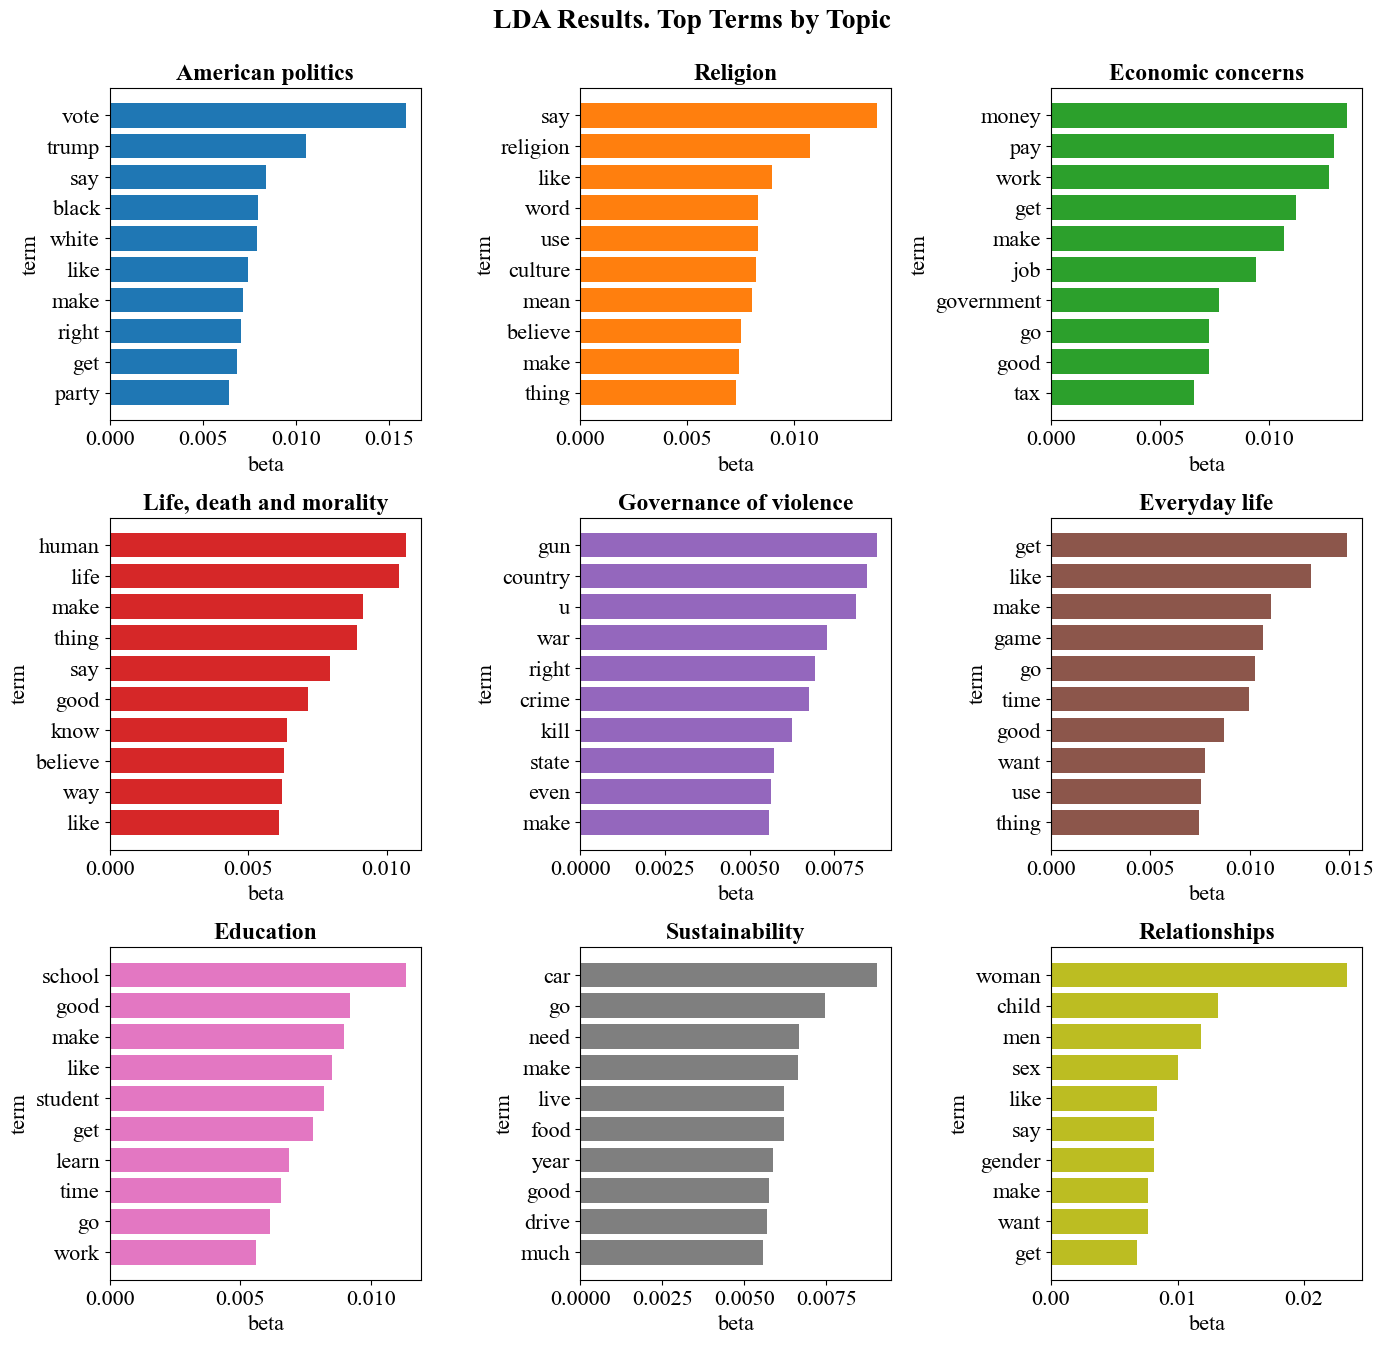

<Figure size 640x480 with 0 Axes>

In [45]:
# Custom topic names
topic_names = {
    1: "American politics",
    2: "Religion",
    3: "Economic concerns",
    4: "Life, death and morality",
    5: "Governance of violence",
    6: "Everyday life",
    7: "Education",
    8: "Sustainability",
    9: "Relationships"
}

def plot_lda_top_words(term_topic_matrix, n_top_words=10):
    n_topics = term_topic_matrix.shape[1]
    cols = 3  # Number of columns in the grid (changed from 3 to 2)
    rows = (n_topics // cols) + (1 if n_topics % cols != 0 else 0)
    
    # Create the figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4.5), sharex=False)
    axes = axes.flatten()
    
    # Add global title
    fig.suptitle('LDA Results. Top Terms by Topic', 
                 fontsize=20, fontweight='bold', y=0.995)
    
    for i, topic in enumerate(term_topic_matrix.columns):
        # Get top words and their scores, sorted ascending for the horizontal bar chart
        top_data = term_topic_matrix[topic].nlargest(n_top_words).sort_values(ascending=True)
        
        ax = axes[i]
        ax.barh(top_data.index, top_data.values, color=plt.cm.tab10(i % 10))
        
        # Setting the Title with custom topic name
        topic_num = i + 1
        topic_name = topic_names.get(topic_num, f"Topic {topic_num}")
        ax.set_title(f"{topic_name}", fontweight='bold', fontsize=17)
        
        ax.set_xlabel('beta', fontsize=16)
        ax.set_ylabel('term', fontsize=16)
        
        # Cleaning up tick appearance
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
    
    # Hide any unused subplots if n_topics is not a multiple of cols
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    # Adjust layout to prevent label overlapping
    plt.tight_layout()
    plt.show()
    plt.savefig('lda_top_words.png', dpi=300, bbox_inches='tight')

# Call the function
plot_lda_top_words(reddit_term_topic_matrix_lda, n_top_words=10)

In [46]:
# ===== LIWC Scores Visualization with Statistical Tests =====

# 1. Updated dictionary including specific emotion subcategories
liwc_vars = {
    'liwc_scores.analytic': 'Analytic Thinking',
    'liwc_scores.authentic': 'Authenticity',
    'liwc_scores.tone': 'Emotional Tone',
    'liwc_scores.categories.anx': 'Anxiety',
    'liwc_scores.categories.anger': 'Anger',
    'liwc_scores.categories.sad': 'Sadness'
}

# 2. Calculate the means per topic
existing_cols = [col for col in liwc_vars.keys() if col in ds_reddit.columns]
topic_means = ds_reddit.groupby('top_topic_1')[existing_cols].mean().reset_index()

# Add custom topic names to the dataframe
# Extract numeric part from 'topic_X' strings and add 1 to match dictionary keys
topic_means['topic_label'] = topic_means['top_topic_1'].apply(
    lambda x: topic_names.get(int(x.split('_')[1]) + 1, x)
)

# Create numeric x-axis positions for plotting
topic_means['x_position'] = topic_means['top_topic_1'].apply(
    lambda x: int(x.split('_')[1])
)
topic_means = topic_means.sort_values('x_position')

# Prepare data by topic groups for statistical tests
topic_groups = {}
for topic_id in ds_reddit['top_topic_1'].unique():
    topic_groups[topic_id] = ds_reddit[ds_reddit['top_topic_1'] == topic_id]

# Dictionary to store test results for each variable
test_results = {}

# ===== STATISTICAL ANALYSIS: Detailed Output =====

print("\n" + "="*80)
print("STATISTICAL ANALYSIS: Normality Tests and ANOVA/Kruskal-Wallis")
print("="*80)

for col_name in existing_cols:
    display_name = liwc_vars[col_name]
    print(f"\n{'='*80}")
    print(f"VARIABLE: {display_name} ({col_name})")
    print(f"{'='*80}")
    
    # Collect data for each topic (sorted)
    topic_data = []
    sorted_topic_ids = sorted(topic_groups.keys(), key=lambda x: int(x.split('_')[1]))
    
    for topic_id in sorted_topic_ids:
        data = topic_groups[topic_id][col_name].dropna()
        topic_data.append(data)
        
    # ===== NORMALITY TESTS =====
    print("\n--- Normality Tests (Shapiro-Wilk) ---")
    print(f"{'Topic':<25} {'n':<8} {'W-statistic':<15} {'p-value':<15} {'Normal?'}")
    print("-" * 80)
    
    normality_results = []
    for topic_id, data in zip(sorted_topic_ids, topic_data):
        topic_num = int(topic_id.split('_')[1]) + 1
        topic_name = topic_names.get(topic_num, f"Topic {topic_num}")
        
        if len(data) >= 3:
            if len(data) > 5000:
                data_sample = data.sample(n=5000, random_state=42)
                w_stat, p_value = shapiro(data_sample)
                note = " (sampled)"
            else:
                w_stat, p_value = shapiro(data)
                note = ""
            
            is_normal = "Yes" if p_value > 0.05 else "No"
            normality_results.append(p_value > 0.05)
            
            print(f"{topic_name:<25} {len(data):<8} {w_stat:<15.4f} {p_value:<15.4e} {is_normal}{note}")
        else:
            print(f"{topic_name:<25} {len(data):<8} {'N/A':<15} {'N/A':<15} {'Insufficient data'}")
            normality_results.append(False)
    
    # ===== HOMOGENEITY OF VARIANCE TEST =====
    print("\n--- Levene's Test for Homogeneity of Variance ---")
    try:
        levene_stat, levene_p = levene(*topic_data)
        equal_var = "Yes" if levene_p > 0.05 else "No"
        print(f"Levene's statistic: {levene_stat:.4f}")
        print(f"p-value: {levene_p:.4e}")
        print(f"Equal variances assumption met? {equal_var}")
    except Exception as e:
        print(f"Could not perform Levene's test: {e}")
        equal_var = "Unknown"
    
    # ===== DECISION AND APPROPRIATE TEST =====
    all_normal = all(normality_results)
    mostly_normal = sum(normality_results) / len(normality_results) >= 0.7
    
    print("\n--- Test Selection ---")
    if all_normal:
        print("✓ All groups appear normally distributed")
        print("✓ Parametric test (ANOVA) is appropriate")
        use_anova = True
    elif mostly_normal:
        print("⚠ Most groups appear normally distributed")
        print("⚠ ANOVA is reasonably robust, but consider results cautiously")
        use_anova = True
    else:
        print("✗ Many groups violate normality assumption")
        print("✗ Non-parametric test (Kruskal-Wallis) is more appropriate")
        use_anova = False
    
    # ===== PERFORM APPROPRIATE TEST =====
    print("\n--- Statistical Test Results ---")
    
    if use_anova:
        f_stat, p_value = f_oneway(*topic_data)
        print(f"One-Way ANOVA:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  p-value: {p_value:.4e}")
        
        if p_value < 0.001:
            print(f"  *** Highly significant difference between topics (p < 0.001)")
        elif p_value < 0.01:
            print(f"  ** Significant difference between topics (p < 0.01)")
        elif p_value < 0.05:
            print(f"  * Significant difference between topics (p < 0.05)")
        else:
            print(f"  No significant difference between topics (p >= 0.05)")
    else:
        h_stat, p_value = kruskal(*topic_data)
        print(f"Kruskal-Wallis H-test (non-parametric):")
        print(f"  H-statistic: {h_stat:.4f}")
        print(f"  p-value: {p_value:.4e}")
        
        if p_value < 0.001:
            print(f"  *** Highly significant difference between topics (p < 0.001)")
        elif p_value < 0.01:
            print(f"  ** Significant difference between topics (p < 0.01)")
        elif p_value < 0.05:
            print(f"  * Significant difference between topics (p < 0.05)")
        else:
            print(f"  No significant difference between topics (p >= 0.05)")
    
    # Display descriptive statistics
    print("\n--- Descriptive Statistics by Topic ---")
    print(f"{'Topic':<25} {'Mean':<12} {'Median':<12} {'Std Dev':<12} {'Min':<12} {'Max'}")
    print("-" * 90)
    for topic_id, data in zip(sorted_topic_ids, topic_data):
        topic_num = int(topic_id.split('_')[1]) + 1
        topic_name = topic_names.get(topic_num, f"Topic {topic_num}")
        print(f"{topic_name:<25} {data.mean():<12.4f} {data.median():<12.4f} "
              f"{data.std():<12.4f} {data.min():<12.4f} {data.max():<12.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


STATISTICAL ANALYSIS: Normality Tests and ANOVA/Kruskal-Wallis

VARIABLE: Analytic Thinking (liwc_scores.analytic)

--- Normality Tests (Shapiro-Wilk) ---
Topic                     n        W-statistic     p-value         Normal?
--------------------------------------------------------------------------------
American politics         641      0.9930          4.2114e-03      No
Religion                  457      0.9962          3.5686e-01      Yes
Economic concerns         570      0.9936          1.6602e-02      No
Life, death and morality  643      0.9950          3.4252e-02      No
Governance of violence    526      0.9943          4.6279e-02      No
Everyday life             665      0.9949          2.6699e-02      No
Education                 505      0.9977          7.2245e-01      Yes
Sustainability            274      0.9873          1.6571e-02      No
Relationships             732      0.9953          2.4790e-02      No

--- Levene's Test for Homogeneity of Variance ---
Leven

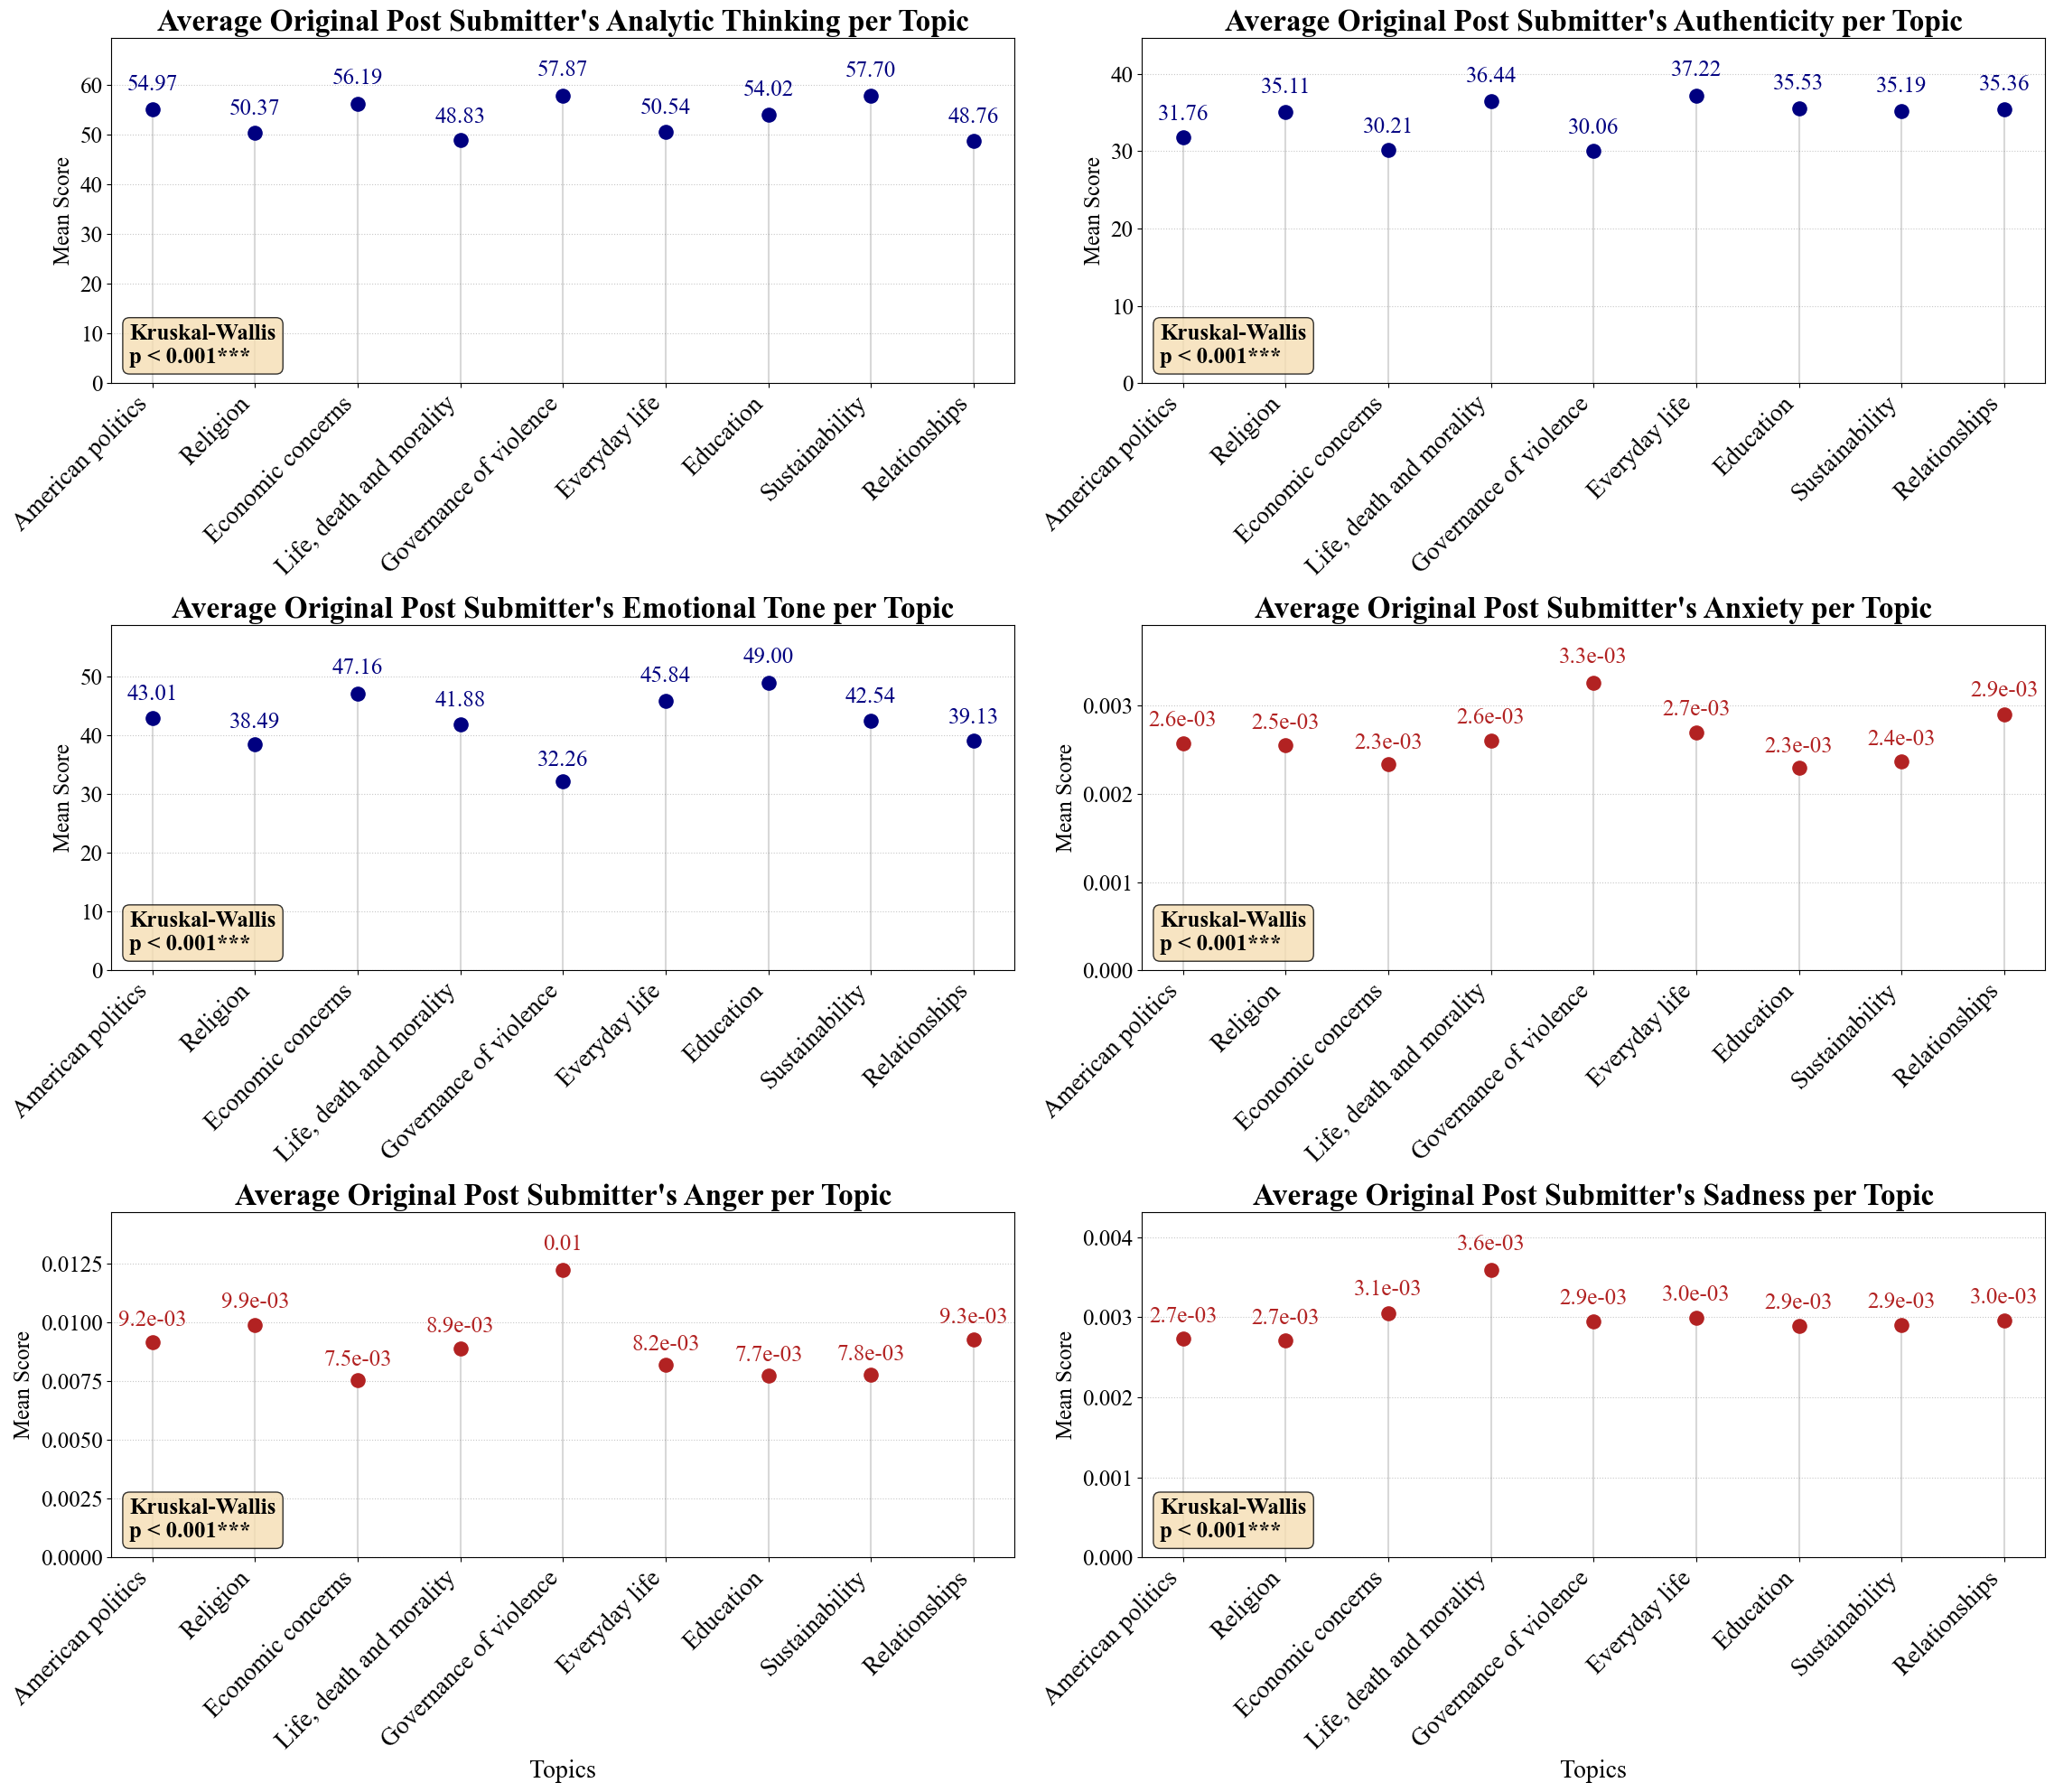

In [57]:
# ===== LIWC Scores Visualization with Statistical Tests =====

# 1. Updated dictionary including specific emotion subcategories
liwc_vars = {
    'liwc_scores.analytic': 'Analytic Thinking',
    'liwc_scores.authentic': 'Authenticity',
    'liwc_scores.tone': 'Emotional Tone',
    'liwc_scores.categories.anx': 'Anxiety',
    'liwc_scores.categories.anger': 'Anger',
    'liwc_scores.categories.sad': 'Sadness'
}

# 2. Calculate the means per topic
existing_cols = [col for col in liwc_vars.keys() if col in ds_reddit.columns]
topic_means = ds_reddit.groupby('top_topic_1')[existing_cols].mean().reset_index()

# Add custom topic names to the dataframe
topic_means['topic_label'] = topic_means['top_topic_1'].apply(
    lambda x: topic_names.get(int(x.split('_')[1]) + 1, x)
)

# Create numeric x-axis positions for plotting
topic_means['x_position'] = topic_means['top_topic_1'].apply(
    lambda x: int(x.split('_')[1])
)
topic_means = topic_means.sort_values('x_position')

# Prepare data by topic groups for statistical tests
topic_groups = {}
for topic_id in ds_reddit['top_topic_1'].unique():
    topic_groups[topic_id] = ds_reddit[ds_reddit['top_topic_1'] == topic_id]

# Dictionary to store test results for each variable
test_results = {}

# Perform normality tests and appropriate statistical tests for each variable
for col_name in existing_cols:
    # Collect data for each topic
    topic_data = []
    sorted_topic_ids = sorted(topic_groups.keys(), key=lambda x: int(x.split('_')[1]))
    
    for topic_id in sorted_topic_ids:
        data = topic_groups[topic_id][col_name].dropna()
        topic_data.append(data)
    
    # Check normality for each group
    normality_results = []
    for data in topic_data:
        if len(data) >= 3:
            if len(data) > 5000:
                data_sample = data.sample(n=5000, random_state=42)
                _, p_value = shapiro(data_sample)
            else:
                _, p_value = shapiro(data)
            normality_results.append(p_value > 0.05)
        else:
            normality_results.append(False)
    
    # Decide which test to use
    all_normal = all(normality_results)
    mostly_normal = sum(normality_results) / len(normality_results) >= 0.7
    
    if all_normal or mostly_normal:
        # Use ANOVA
        f_stat, p_value = f_oneway(*topic_data)
        test_type = "ANOVA"
        test_stat = f_stat
    else:
        # Use Kruskal-Wallis
        h_stat, p_value = kruskal(*topic_data)
        test_type = "Kruskal-Wallis"
        test_stat = h_stat
    
    test_results[col_name] = {
        'test_type': test_type,
        'test_stat': test_stat,
        'p_value': p_value
    }

# 3. Set up the figure in a 3x2 grid
n_vars = len(existing_cols)
fig, axes = plt.subplots(3, 2, figsize=(23, 20))

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, col_name in enumerate(existing_cols):
    display_name = liwc_vars[col_name]
    ax = axes_flat[i]
    
    # Create the 'sticks' 
    ax.vlines(x=topic_means['x_position'], ymin=0, ymax=topic_means[col_name], 
              color='gray', alpha=0.3, linewidth=1.5)
    
    # Create the 'candies' 
    dot_color = 'firebrick' if 'categories' in col_name else 'navy'
    
    ax.scatter(x=topic_means['x_position'], y=topic_means[col_name], 
               color=dot_color, s=120, zorder=3)
    
    # Add value labels above each dot
    for x, y in zip(topic_means['x_position'], topic_means[col_name]):
        label = f"{y:.1e}" if 0 < y < 0.01 else f"{y:.2f}"
        
        ax.text(
            x, 
            y + (y * 0.05), 
            label, 
            ha='center', 
            va='bottom', 
            fontsize=18,
            color=dot_color
        )
    
    # Formatting
    ax.set_title(f'Average Original Post Submitter\'s {display_name} per Topic', fontsize=24, fontweight='bold')
    ax.set_ylabel('Mean Score', fontsize=18)
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # Ensure the y-axis starts at 0 to show relative scale
    ax.set_ylim(0, topic_means[col_name].max() * 1.2)
    
    # Set custom x-tick labels with topic names - size set to 12
    ax.set_xticks(topic_means['x_position'])
    ax.set_xticklabels(topic_means['topic_label'], rotation=45, ha='right', fontsize=20)

    ax.tick_params(axis='y', labelsize=18)
    
    # Add statistical test results to the plot
    test_info = test_results[col_name]
    test_type = test_info['test_type']
    p_value = test_info['p_value']
    test_stat = test_info['test_stat']
    
    # Format p-value
    if p_value < 0.001:
        p_text = "p < 0.001***"
    elif p_value < 0.01:
        p_text = f"p = {p_value:.3f}**"
    elif p_value < 0.05:
        p_text = f"p = {p_value:.3f}*"
    else:
        p_text = f"p = {p_value:.3f}"
    
    # Add text box with test results
    textstr = f'{test_type}\n{p_text}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.17, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props, fontweight='bold')

# Label x-axes for bottom row only
axes[2, 0].set_xlabel('Topics', fontsize=20)
axes[2, 1].set_xlabel('Topics', fontsize=20)

plt.tight_layout()
plt.savefig('liwc_topic_means_with_stats.png', dpi=300, bbox_inches='tight')
plt.show()

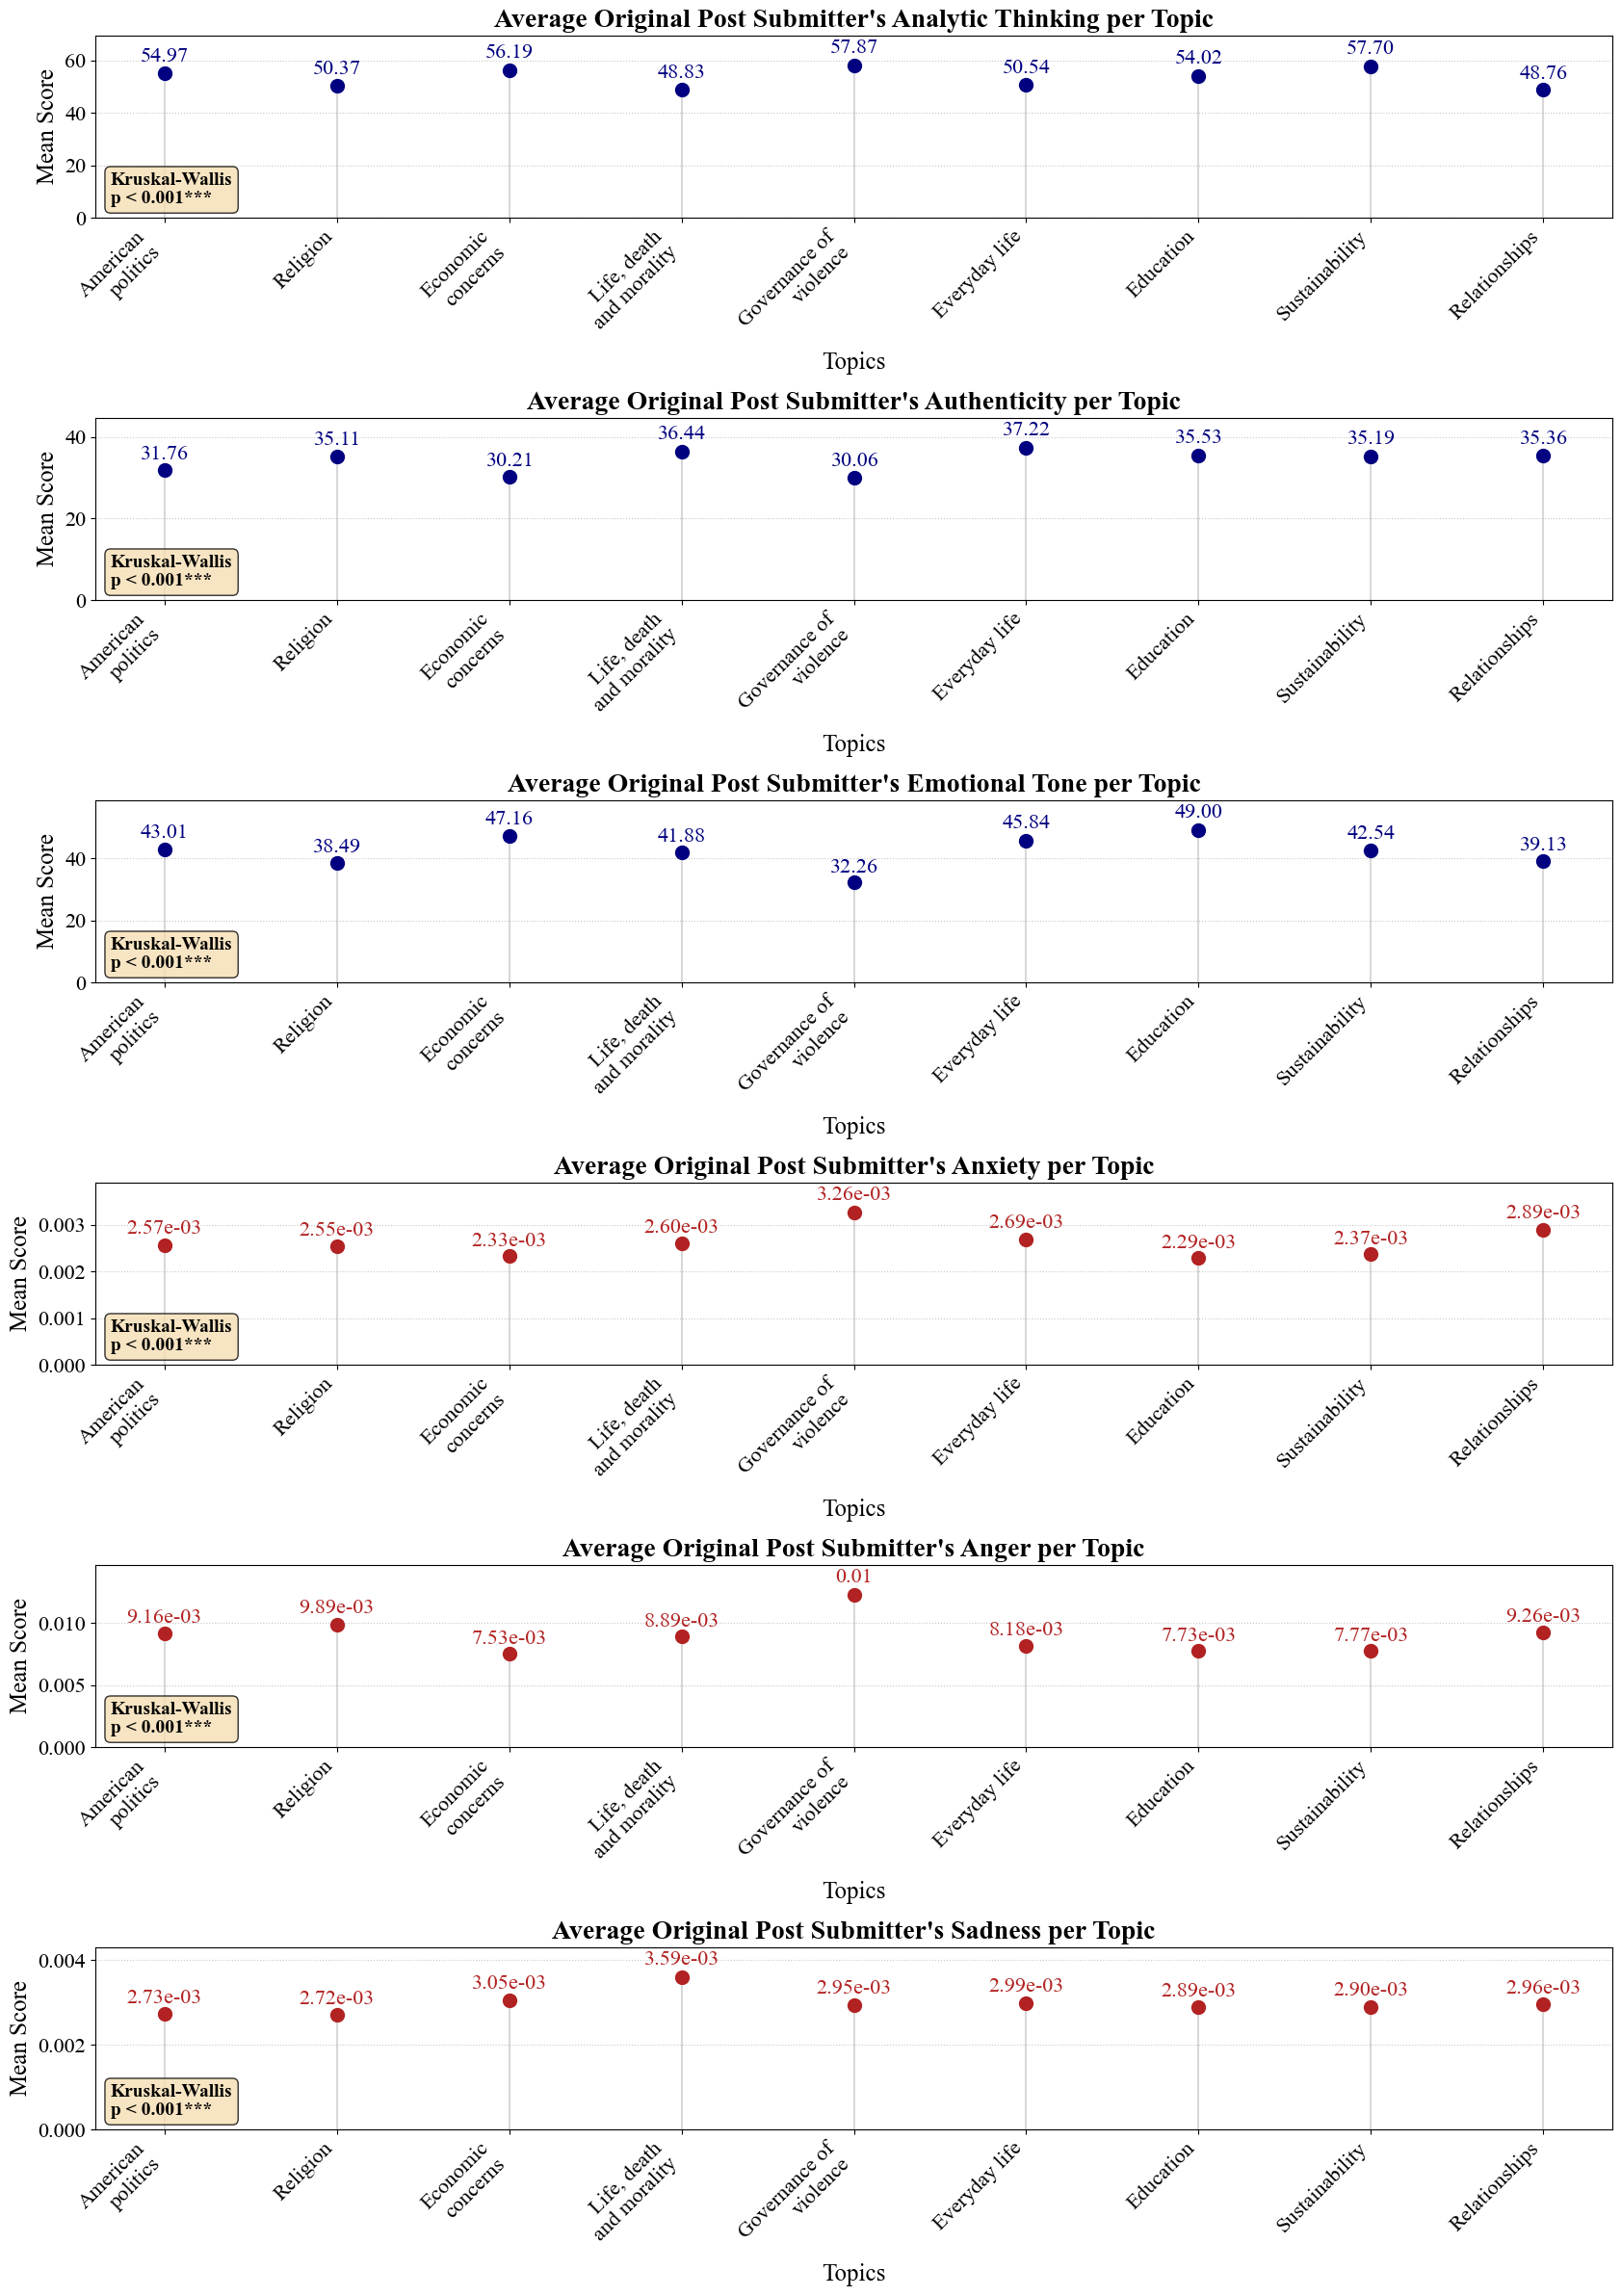

In [88]:
# ===== LIWC Scores Visualization with Statistical Tests =====
topic_names = {
    1: "American\npolitics",
    2: "Religion",
    3: "Economic\nconcerns",
    4: "Life, death\nand morality",
    5: "Governance of\nviolence",
    6: "Everyday life",
    7: "Education",
    8: "Sustainability",
    9: "Relationships"
}
# 1. Updated dictionary including specific emotion subcategories
liwc_vars = {
    'liwc_scores.analytic': 'Analytic Thinking',
    'liwc_scores.authentic': 'Authenticity',
    'liwc_scores.tone': 'Emotional Tone',
    'liwc_scores.categories.anx': 'Anxiety',
    'liwc_scores.categories.anger': 'Anger',
    'liwc_scores.categories.sad': 'Sadness'
}

# 2. Calculate the means per topic
existing_cols = [col for col in liwc_vars.keys() if col in ds_reddit.columns]
topic_means = ds_reddit.groupby('top_topic_1')[existing_cols].mean().reset_index()

# Add custom topic names to the dataframe
topic_means['topic_label'] = topic_means['top_topic_1'].apply(
    lambda x: topic_names.get(int(x.split('_')[1]) + 1, x)
)

# Create numeric x-axis positions for plotting
topic_means['x_position'] = topic_means['top_topic_1'].apply(
    lambda x: int(x.split('_')[1])
)
topic_means = topic_means.sort_values('x_position')

# Prepare data by topic groups for statistical tests
topic_groups = {}
for topic_id in ds_reddit['top_topic_1'].unique():
    topic_groups[topic_id] = ds_reddit[ds_reddit['top_topic_1'] == topic_id]

# Dictionary to store test results for each variable
test_results = {}

# Perform normality tests and appropriate statistical tests for each variable
for col_name in existing_cols:
    # Collect data for each topic
    topic_data = []
    sorted_topic_ids = sorted(topic_groups.keys(), key=lambda x: int(x.split('_')[1]))
    
    for topic_id in sorted_topic_ids:
        data = topic_groups[topic_id][col_name].dropna()
        topic_data.append(data)
    
    # Check normality for each group
    normality_results = []
    for data in topic_data:
        if len(data) >= 3:
            if len(data) > 5000:
                data_sample = data.sample(n=5000, random_state=42)
                _, p_value = shapiro(data_sample)
            else:
                _, p_value = shapiro(data)
            normality_results.append(p_value > 0.05)
        else:
            normality_results.append(False)
    
    # Decide which test to use
    all_normal = all(normality_results)
    mostly_normal = sum(normality_results) / len(normality_results) >= 0.7
    
    if all_normal or mostly_normal:
        # Use ANOVA
        f_stat, p_value = f_oneway(*topic_data)
        test_type = "ANOVA"
        test_stat = f_stat
    else:
        # Use Kruskal-Wallis
        h_stat, p_value = kruskal(*topic_data)
        test_type = "Kruskal-Wallis"
        test_stat = h_stat
    
    test_results[col_name] = {
        'test_type': test_type,
        'test_stat': test_stat,
        'p_value': p_value
    }

# 3. Set up the figure in a 6x1 grid (one plot per row)
n_vars = len(existing_cols)
fig, axes = plt.subplots(n_vars, 1, figsize=(17, 4 * n_vars))

# Ensure axes is always iterable
if n_vars == 1:
    axes = [axes]

for i, col_name in enumerate(existing_cols):
    display_name = liwc_vars[col_name]
    ax = axes[i]
    
    # Create the 'sticks' 
    ax.vlines(x=topic_means['x_position'], ymin=0, ymax=topic_means[col_name], 
              color='gray', alpha=0.3, linewidth=1.5)
    
    # Create the 'candies' 
    dot_color = 'firebrick' if 'categories' in col_name else 'navy'
    
    ax.scatter(x=topic_means['x_position'], y=topic_means[col_name], 
               color=dot_color, s=100, zorder=3)
    
    # Add value labels above each dot
    for x, y in zip(topic_means['x_position'], topic_means[col_name]):
        label = f"{y:.2e}" if 0 < y < 0.01 else f"{y:.2f}"
        
        ax.text(
            x, 
            y + (y * 0.05), 
            label, 
            ha='center', 
            va='bottom', 
            fontsize=16,
            color=dot_color
        )
    
    # Formatting
    ax.set_title(f'Average Original Post Submitter\'s {display_name} per Topic', fontsize=20, fontweight='bold')
    ax.set_ylabel('Mean Score', fontsize=18)
    ax.set_xlabel('Topics', fontsize=18)
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    # Ensure the y-axis starts at 0 to show relative scale
    ax.set_ylim(0, topic_means[col_name].max() * 1.2)
    
    # Set custom x-tick labels with topic names
    ax.set_xticks(topic_means['x_position'])
    ax.set_xticklabels(topic_means['topic_label'], rotation=45, ha='right', fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    # Add statistical test results to the plot
    test_info = test_results[col_name]
    test_type = test_info['test_type']
    p_value = test_info['p_value']
    test_stat = test_info['test_stat']
    
    # Format p-value
    if p_value < 0.001:
        p_text = "p < 0.001***"
    elif p_value < 0.01:
        p_text = f"p = {p_value:.3f}**"
    elif p_value < 0.05:
        p_text = f"p = {p_value:.3f}*"
    else:
        p_text = f"p = {p_value:.3f}"
    
    # Add text box with test results
    textstr = f'{test_type}\n{p_text}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.01, 0.25, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props, fontweight='bold')

plt.tight_layout()
plt.savefig('liwc_topic_means_with_stats.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
ds_reddit.to_csv('ds_reddit_with_topics.csv', index=False)

In [65]:
# Show rows where a column has NaN
len(ds_reddit['submission_author'].unique())

4895